In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Predict Student Results/Code
!ls

/content/drive/.shortcut-targets-by-id/1vG5ZJmw387JNz82DyGFMvnikJmD3EVE8/Predict Student Results/Code
 Clean_data.ipynb    Data.csv	'EDA - part2.ipynb'   train.csv
 data_cleaning.csv   EDA.ipynb	 test.csv


In [ ]:
!pip install --quiet shap==0.39.0

     |████████████████████████████████| 356 kB 12.7 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import lgbE
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)

from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

import shap

%matplotlib inline

sns.set_style('darkgrid')
pd. set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('data_cleaning.csv')

In [ ]:
data

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,diem_ts,hoc_ky,dkhk,tbhk,tctl,tbtl,xlhv,diem_tn,ket_qua_tn,nam_tn
0,A06960,Kế toán doanh nghiệp,Nữ,0,3,A00,20.00,1,22,2.60,22.0,2.60,NaN,3.35,Tốt nghiệp Giỏi,4.0
1,A06961,Kế toán doanh nghiệp,Nữ,0,3,A00,20.00,1,22,2.50,19.0,2.50,NaN,2.55,Tốt nghiệp Khá,4.0
2,A06962,Kế toán doanh nghiệp,Nữ,0,3,A00,20.00,1,22,2.80,22.0,2.80,NaN,3.02,Tốt nghiệp Khá,4.0
3,A06963,Kế toán doanh nghiệp,Nam,0,3,A00,20.00,1,22,2.25,19.0,2.25,NaN,2.52,Tốt nghiệp Khá,4.0
4,A06964,Kế toán doanh nghiệp,Nam,0,3,A00,20.00,1,22,2.20,22.0,2.20,NaN,2.09,Tốt nghiệp Trung bình,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175831,A27495,Ngôn ngữ Anh,Nữ,0,1,D01,25.00,6,24,3.13,122.0,3.24,NaN,3.24,Tốt nghiệp Giỏi,4.0
175832,A27495,Ngôn ngữ Anh,Nữ,0,1,D01,25.00,7,3,2.33,131.0,3.18,NaN,3.24,Tốt nghiệp Giỏi,4.0
175833,A27497,Ngôn ngữ Anh,Nữ,0,1,D01,24.25,5,18,3.33,87.0,2.96,NaN,3.21,Tốt nghiệp Giỏi,4.0
175834,A27497,Ngôn ngữ Anh,Nữ,0,1,D01,24.25,6,21,3.57,108.0,3.09,NaN,3.21,Tốt nghiệp Giỏi,4.0


## Goal

**Target feature**: *ket_qua_tn*

Các class phân bố không đều => Metric: **F1 score**, Precision, Recall

In [ ]:
data.dtypes

id             object
nganh          object
gioi_tinh      object
doi_tuong       int64
khu_vuc        object
khoi_ts        object
diem_ts       float64
hoc_ky         object
dkhk            int64
tbhk          float64
tctl          float64
tbtl          float64
xlhv           object
diem_tn       float64
ket_qua_tn     object
nam_tn        float64
dtype: object

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175836 entries, 0 to 175835
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          175836 non-null  object 
 1   nganh       175836 non-null  object 
 2   gioi_tinh   175836 non-null  object 
 3   doi_tuong   175836 non-null  int64  
 4   khu_vuc     175836 non-null  object 
 5   khoi_ts     175836 non-null  object 
 6   diem_ts     175357 non-null  float64
 7   hoc_ky      175836 non-null  object 
 8   dkhk        175836 non-null  int64  
 9   tbhk        175836 non-null  float64
 10  tctl        175802 non-null  float64
 11  tbtl        175836 non-null  float64
 12  xlhv        3784 non-null    object 
 13  diem_tn     175836 non-null  float64
 14  ket_qua_tn  175836 non-null  object 
 15  nam_tn      175836 non-null  float64
dtypes: float64(6), int64(2), object(8)
memory usage: 21.5+ MB


In [ ]:
data['doi_tuong'] = data['doi_tuong'].astype(str)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175836 entries, 0 to 175835
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          175836 non-null  object 
 1   nganh       175836 non-null  object 
 2   gioi_tinh   175836 non-null  object 
 3   doi_tuong   175836 non-null  object 
 4   khu_vuc     175836 non-null  object 
 5   khoi_ts     175836 non-null  object 
 6   diem_ts     175357 non-null  float64
 7   hoc_ky      175836 non-null  object 
 8   dkhk        175836 non-null  int64  
 9   tbhk        175836 non-null  float64
 10  tctl        175802 non-null  float64
 11  tbtl        175836 non-null  float64
 12  xlhv        3784 non-null    object 
 13  diem_tn     175836 non-null  float64
 14  ket_qua_tn  175836 non-null  object 
 15  nam_tn      175836 non-null  float64
dtypes: float64(6), int64(1), object(9)
memory usage: 21.5+ MB


In [ ]:
# print duplicates
print("Number of duplicates: ", data.duplicated().sum())
print("Unique values per column:")
data.nunique()

Number of duplicates:  483
Unique values per column:


id            24332
nganh            12
gioi_tinh         2
doi_tuong         7
khu_vuc           4
khoi_ts           6
diem_ts         271
hoc_ky           17
dkhk             56
tbhk            334
tctl            151
tbtl            261
xlhv              2
diem_tn         192
ket_qua_tn        4
nam_tn           13
dtype: int64

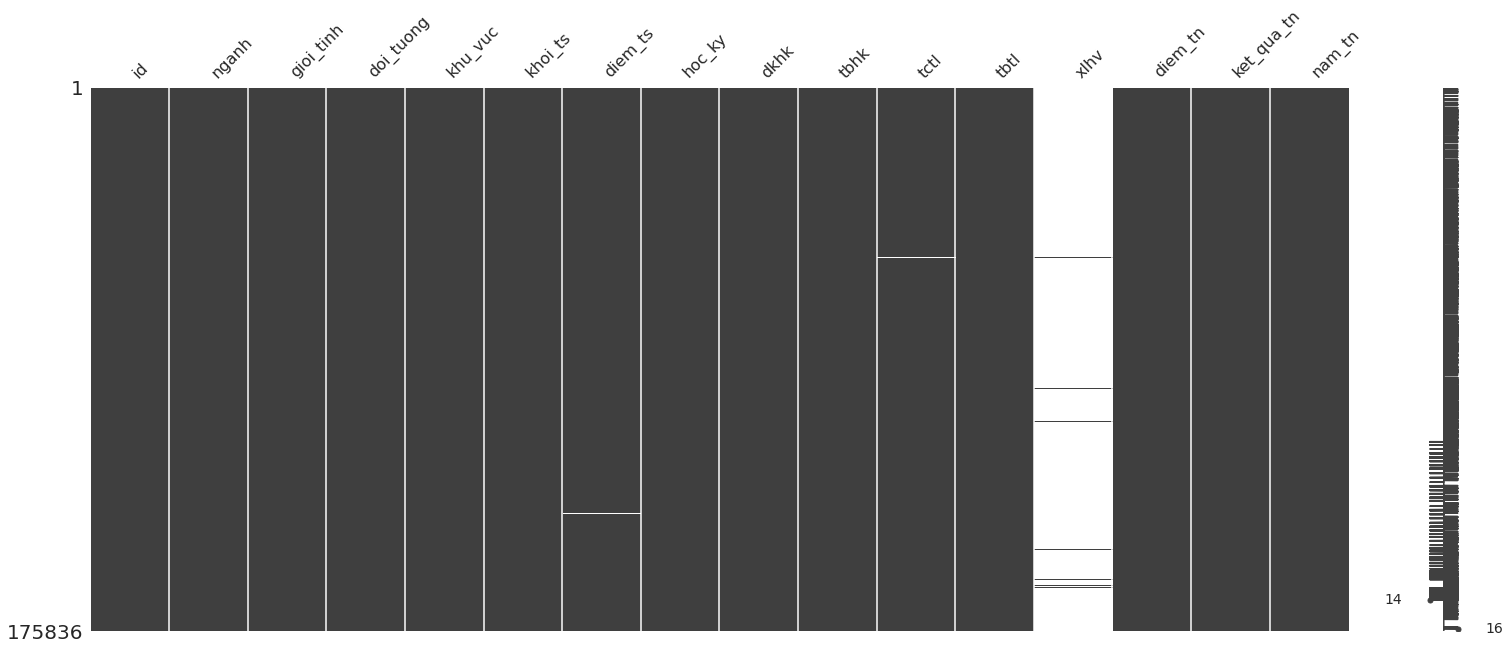

In [ ]:
msno.matrix(data)

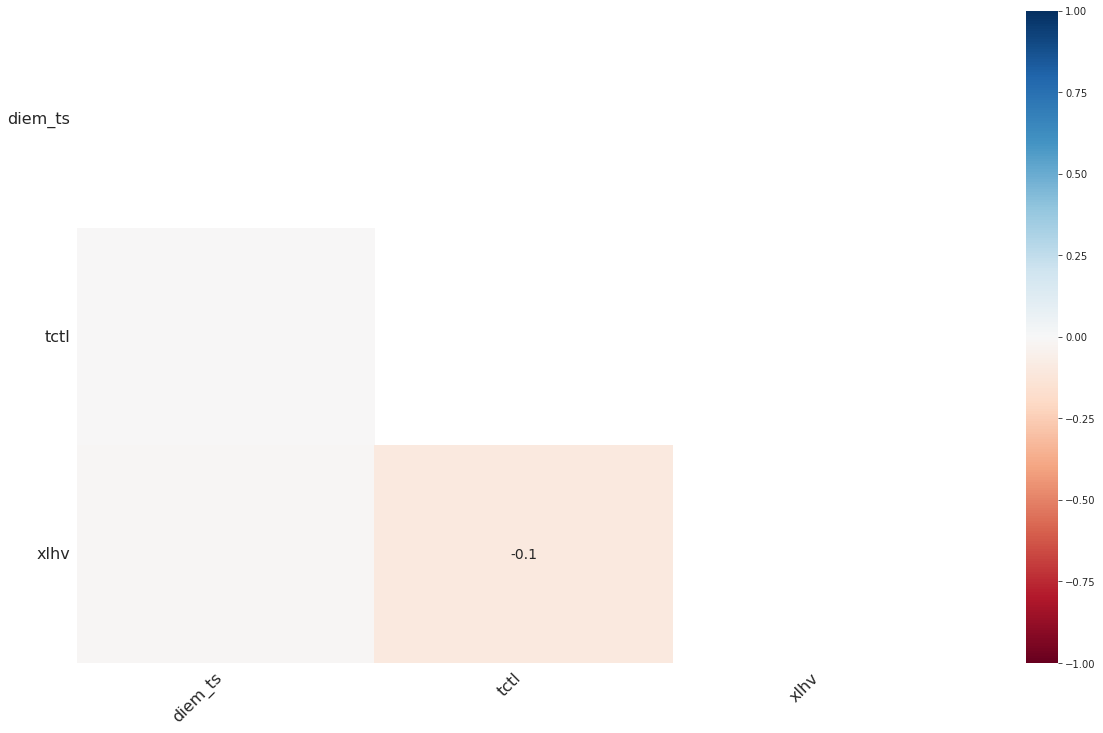

In [ ]:
msno.heatmap(data)

Các feature chứa missing value không có tương quan với nhau

In [ ]:
data['xlhv'].fillna('Binh thuong', inplace = True)

Các chỗ missing vale của *xlhv* có thể hiểu là không bị cảnh cáo học tập

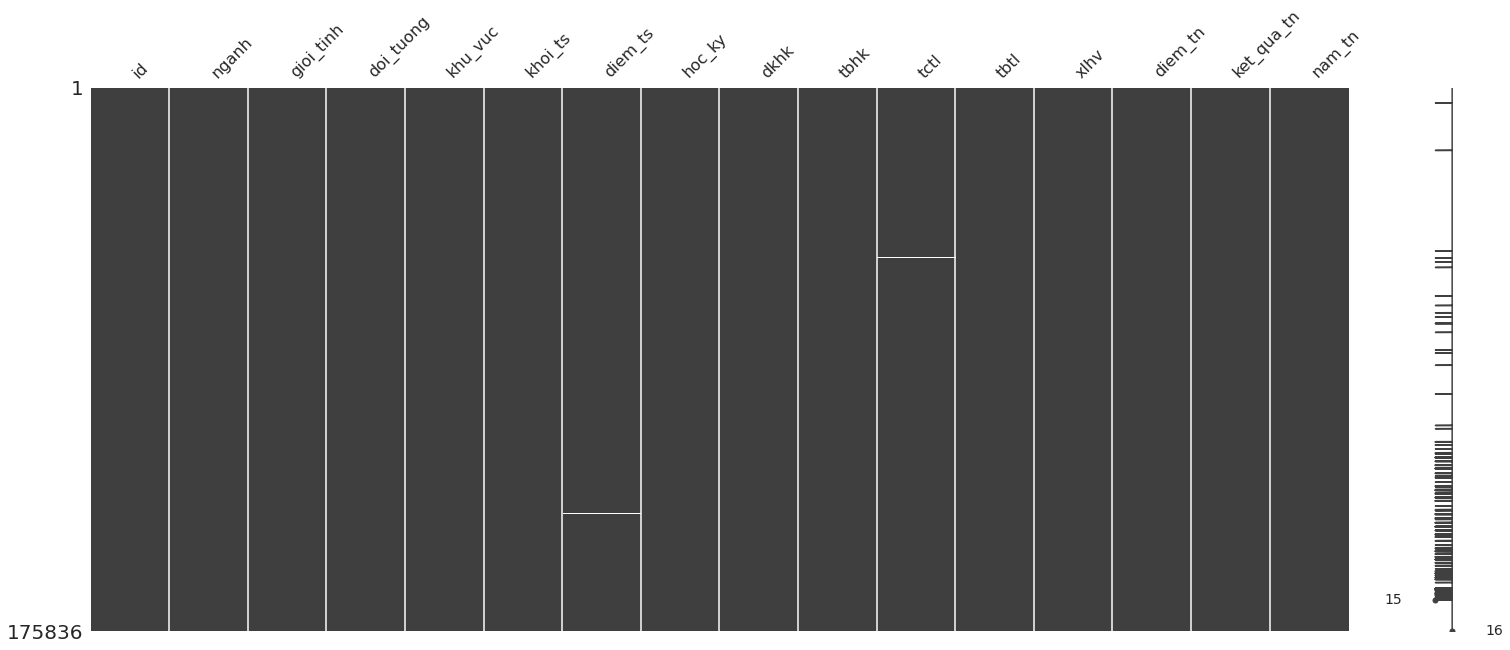

In [ ]:
msno.matrix(data)

Điền các chỗ missing ằng các giá trị xuất hiện nhiều nhất

In [ ]:
def mode_fill(data, column):
    col_mode = data[column].mode()[0]
    data[column].fillna(col_mode, inplace = True)

In [ ]:
mode_fill(data, 'diem_ts')
mode_fill(data, 'tctl')

In [ ]:
data.isna().sum()

id            0
nganh         0
gioi_tinh     0
doi_tuong     0
khu_vuc       0
khoi_ts       0
diem_ts       0
hoc_ky        0
dkhk          0
tbhk          0
tctl          0
tbtl          0
xlhv          0
diem_tn       0
ket_qua_tn    0
nam_tn        0
dtype: int64

# Univariate analysis

## Numerical

In [ ]:
data.describe()

,diem_ts,dkhk,tbhk,tctl,tbtl,diem_tn,nam_tn
count,175836.000000,175836.000000,175836.000000,175836.000000,175836.000000,175836.000000,175836.000000
mean,21.779045,18.064941,2.719822,81.259247,2.731157,2.837548,4.160272
std,2.151598,5.501685,0.736002,40.943768,0.438994,0.419790,0.467681
min,14.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.500000
25%,20.500000,16.000000,2.330000,48.000000,2.440000,2.560000,4.000000
50%,21.750000,18.000000,2.800000,84.000000,2.710000,2.800000,4.000000
75%,23.000000,22.000000,3.200000,116.000000,3.040000,3.160000,4.000000
max,30.000000,72.000000,4.000000,162.000000,4.000000,4.000000,8.500000


In [ ]:
px.violin(
    data,
    x = 'diem_ts',
    box = True,
    points = 'all'
)

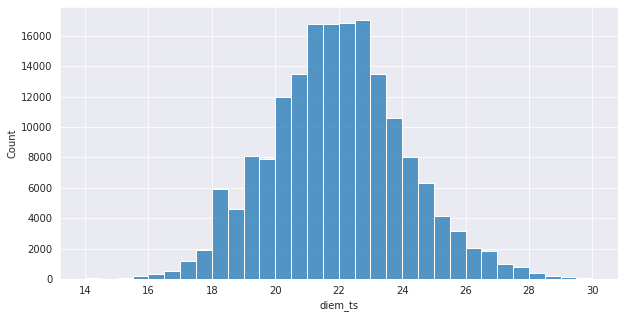

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data['diem_ts'],bins = 32)
plt.show()

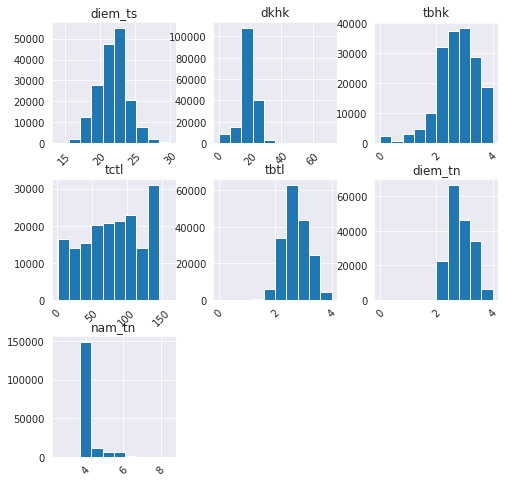

In [ ]:
data.hist(figsize=(8,8), xrot=45)
plt.show()

## Categorical

In [ ]:
data.describe(include='object')

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,hoc_ky,xlhv,ket_qua_tn
count,175836,175836,175836,175836,175836,175836,175836,175836,175836
unique,24332,12,2,7,4,6,17,3,4
top,A06994,Ngân hàng,Nữ,0,2NT,A00,7,Binh thuong,Tốt nghiệp Khá
freq,16,53078,128919,164226,63060,135078,21461,172052,108092


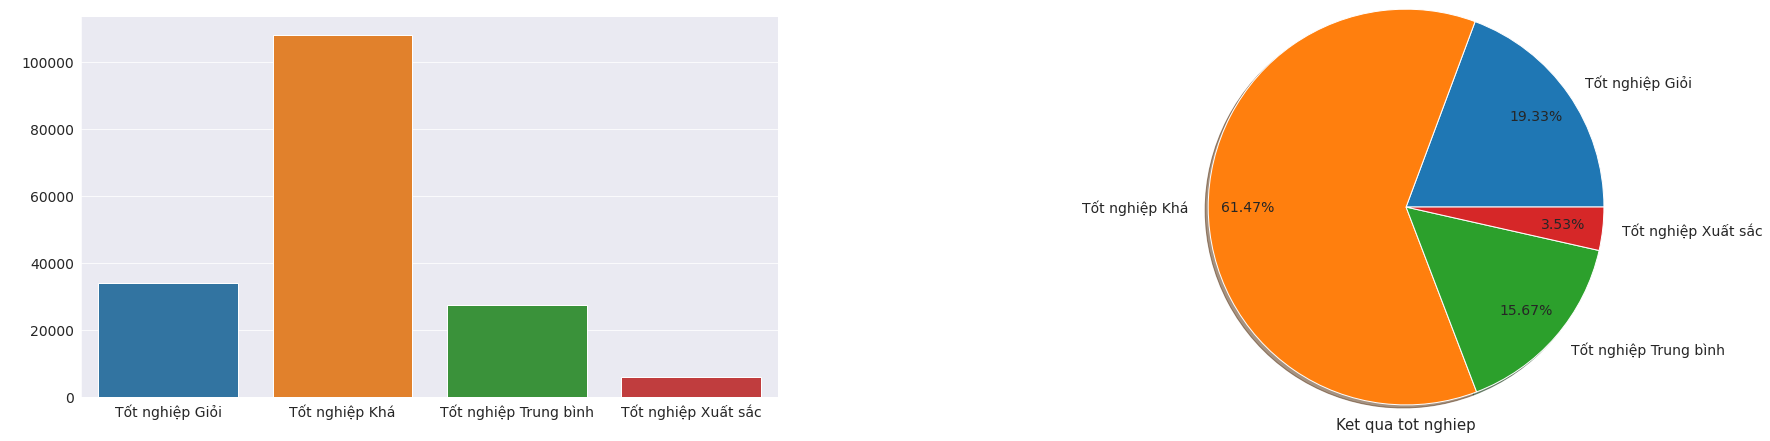

In [ ]:
# checking the target
plt.figure(figsize=(30,7))
# barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=data["ket_qua_tn"])
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right=True)
# pieplot
ax2 = plt.subplot(1,2,2)
plt.pie(data["ket_qua_tn"].value_counts(sort = False),
        labels=list(data["ket_qua_tn"].unique()),
        autopct='%1.2f%%',
        pctdistance=0.8,
        shadow=True,
        radius=1.3,
        textprops={'fontsize':14}
       )
ax2.set_xlabel(" ")
plt.xlabel('Ket qua tot nghiep', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
data['hoc_ky'] = data['hoc_ky'].astype(str)

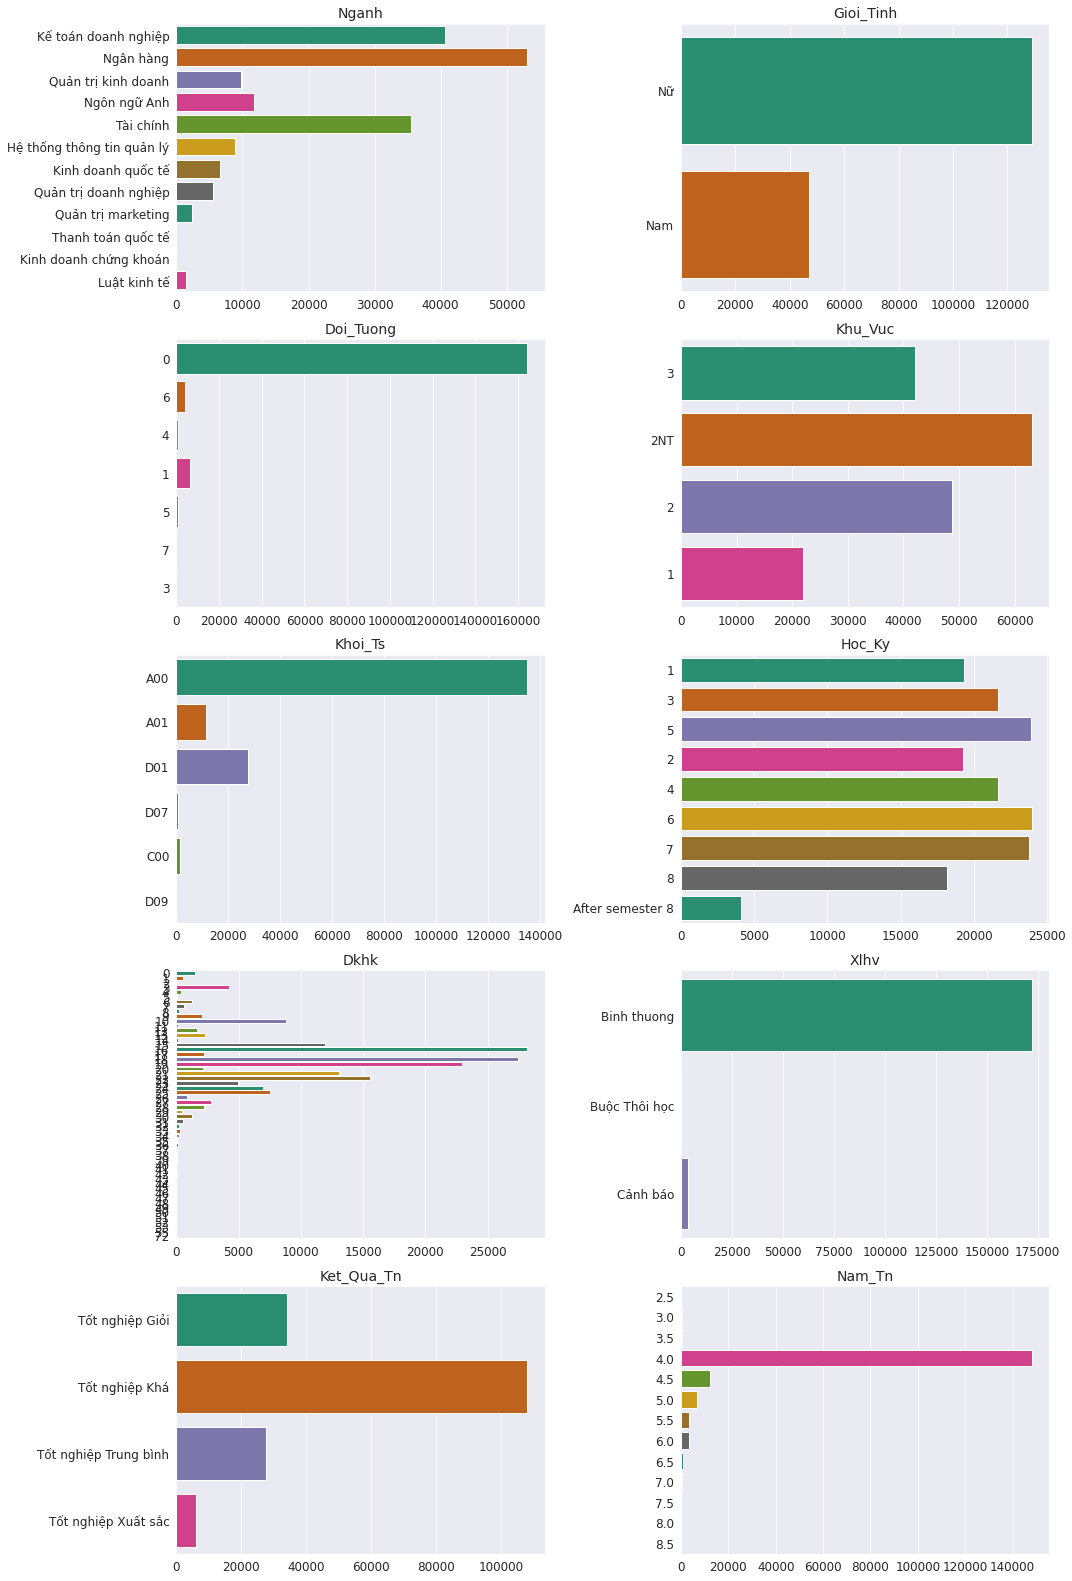

In [ ]:
plt.figure(figsize=(15,70))
plotnumber = 1

for col in data.drop(['id', 'diem_tn', 'diem_ts', 'tbhk', 'tctl', 'tbtl'], axis=1):
    if plotnumber <= data.shape[1]:
        ax1 = plt.subplot(16,2,plotnumber)
        sns.countplot(data=data, y=col, palette='Dark2')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

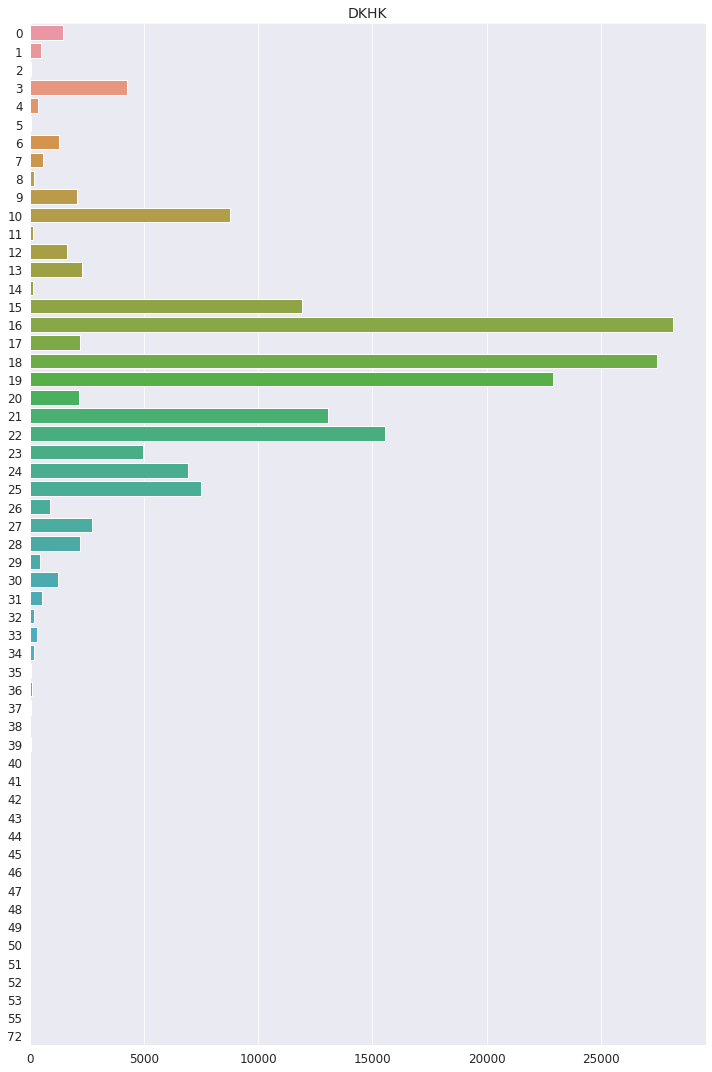

In [ ]:
plt.figure(figsize=(10,15))
sns.countplot(data=data, y='dkhk')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('DKHK', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

**Sao lại đăng kì được 72 tín ????**

# Bivariate analysis

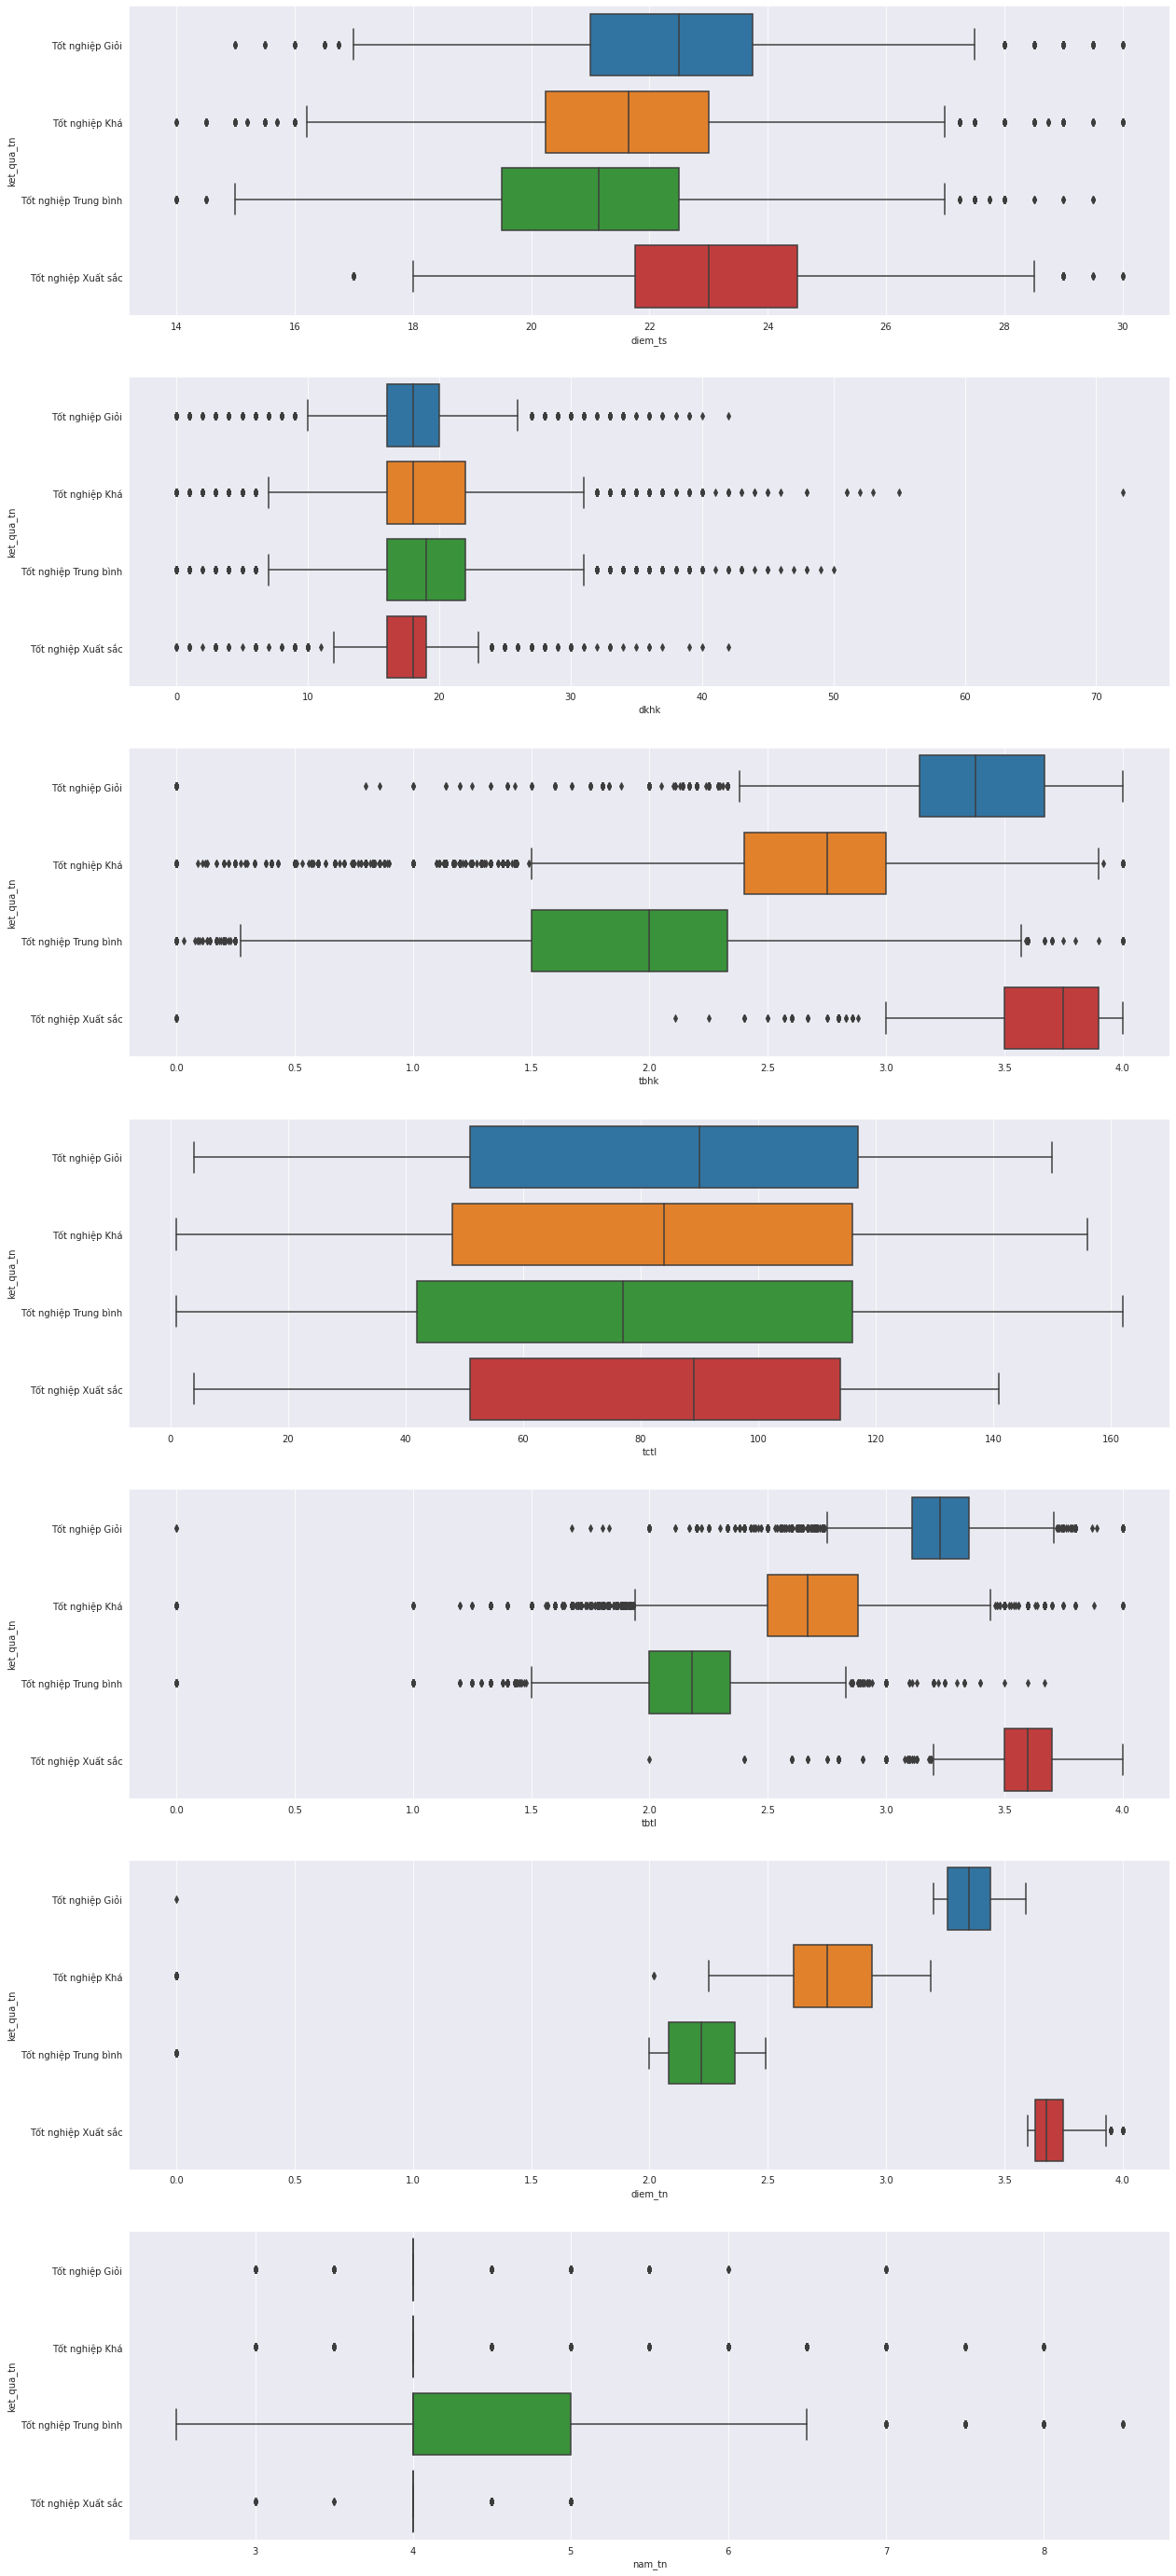

In [ ]:
fig, axs = plt.subplots(7, 1, figsize = (20, 50))
num_cols = ['diem_ts', 'dkhk', 'tbhk', 'tctl', 'tbtl', 'diem_tn', 'nam_tn']
for idx, col in enumerate(num_cols):
    sns.boxplot(y = data['ket_qua_tn'], x = col, data=data, ax = axs[idx])
plt.show()

<Figure size 720x360 with 0 Axes>

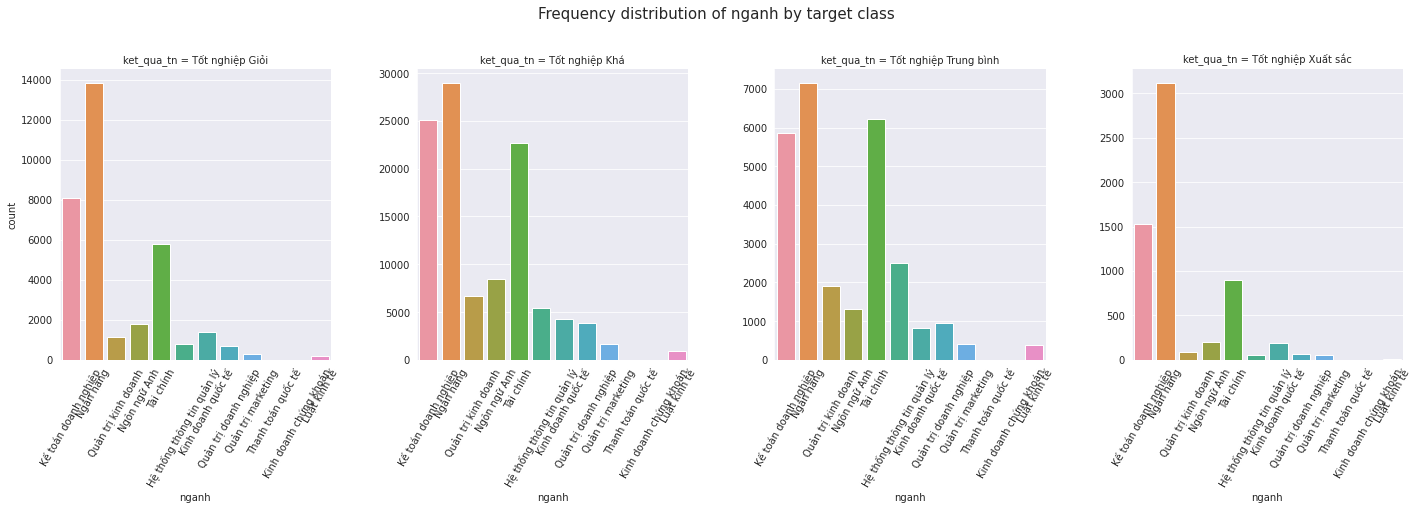

<Figure size 720x360 with 0 Axes>

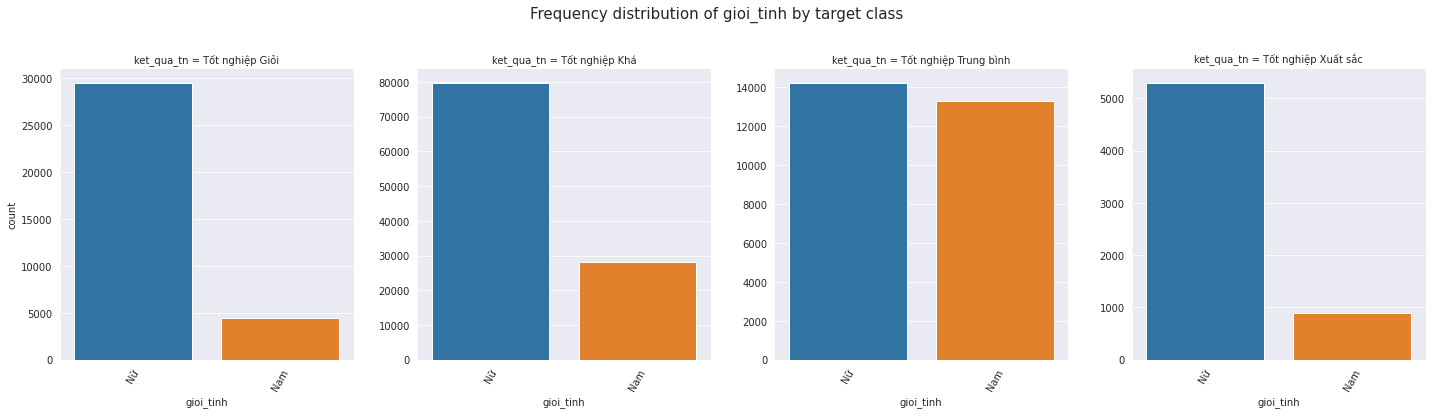

<Figure size 720x360 with 0 Axes>

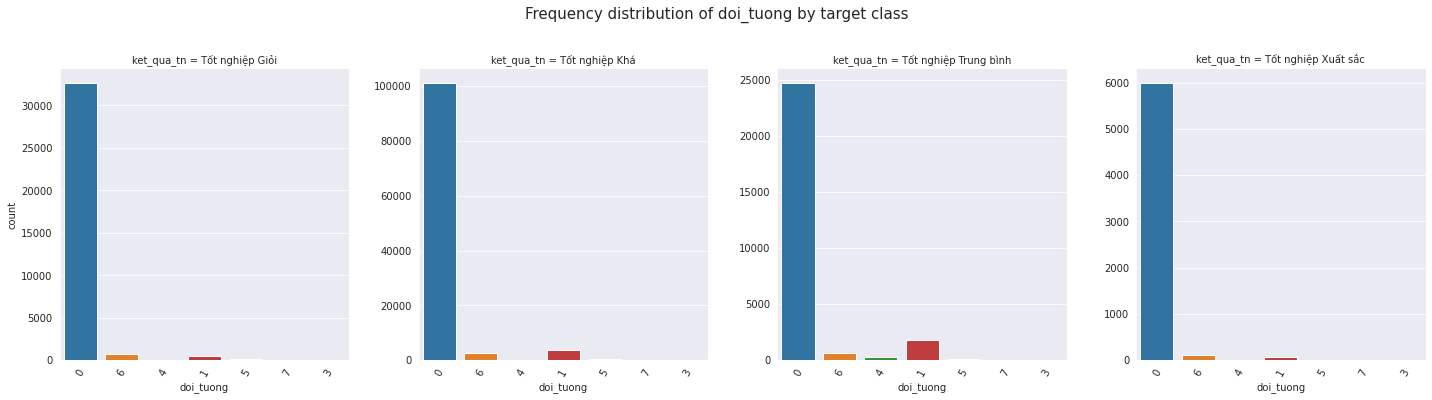

<Figure size 720x360 with 0 Axes>

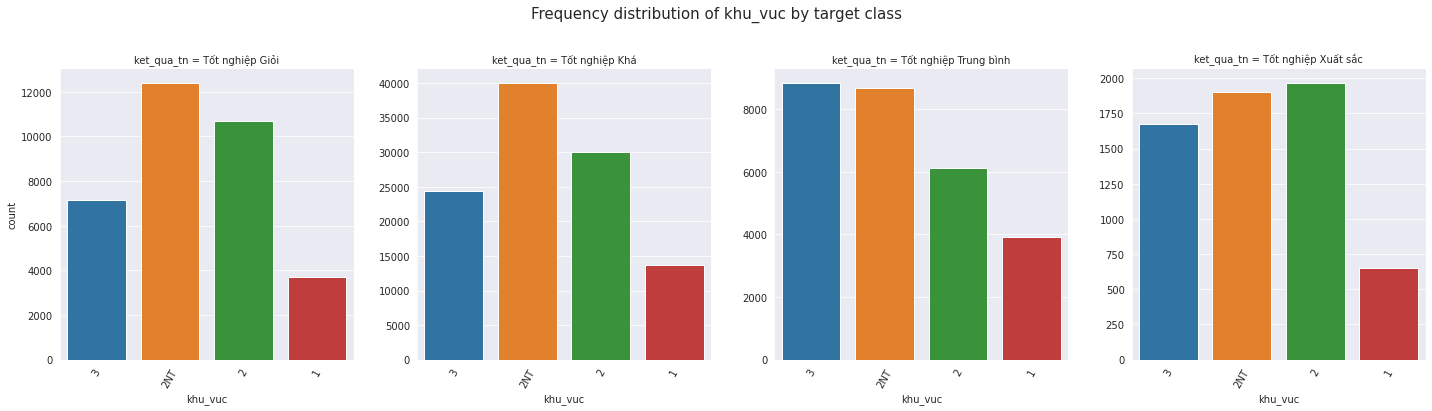

<Figure size 720x360 with 0 Axes>

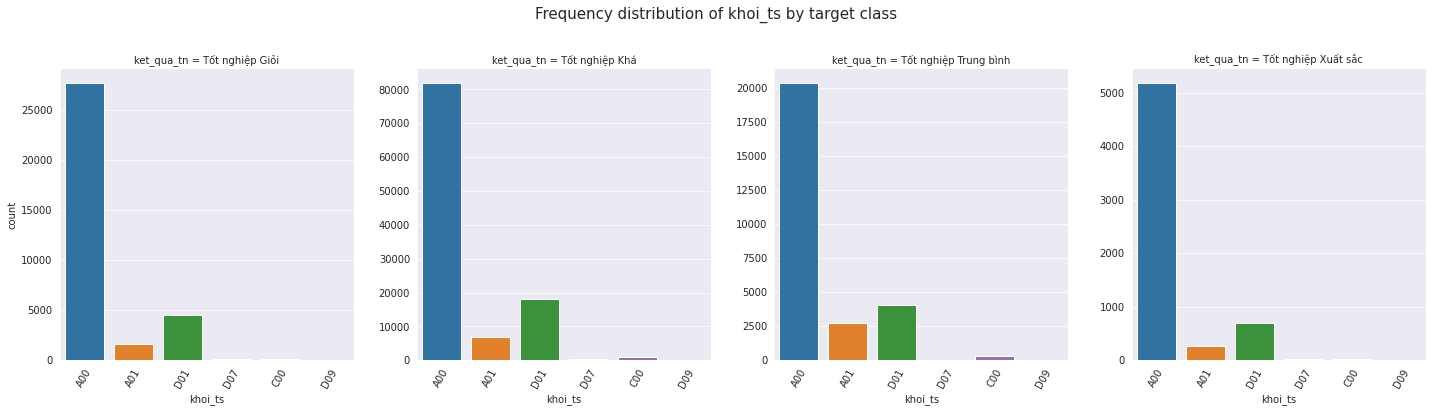

<Figure size 720x360 with 0 Axes>

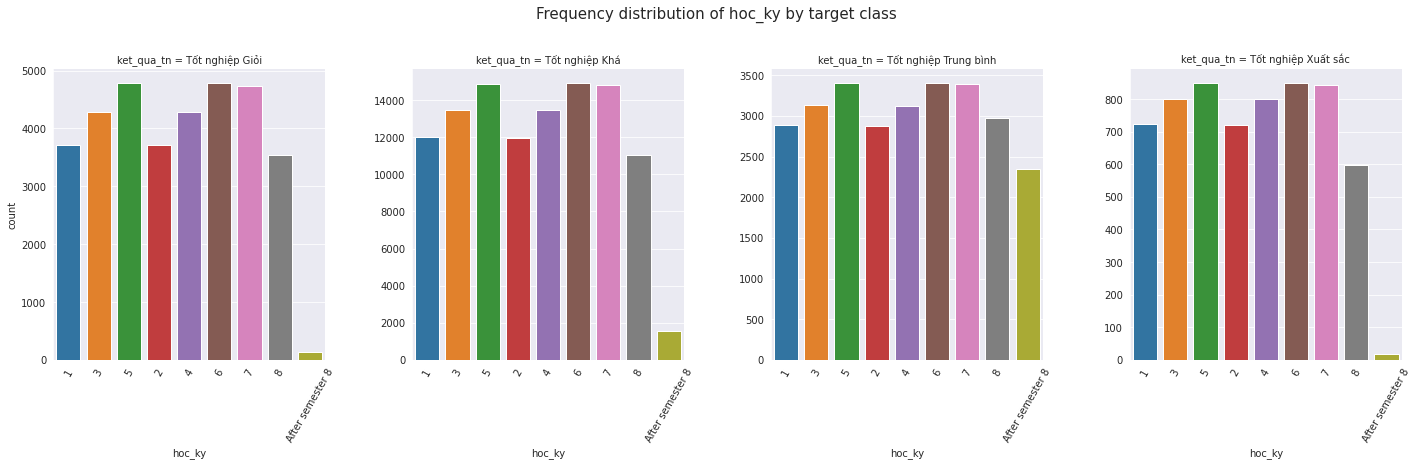

<Figure size 720x360 with 0 Axes>

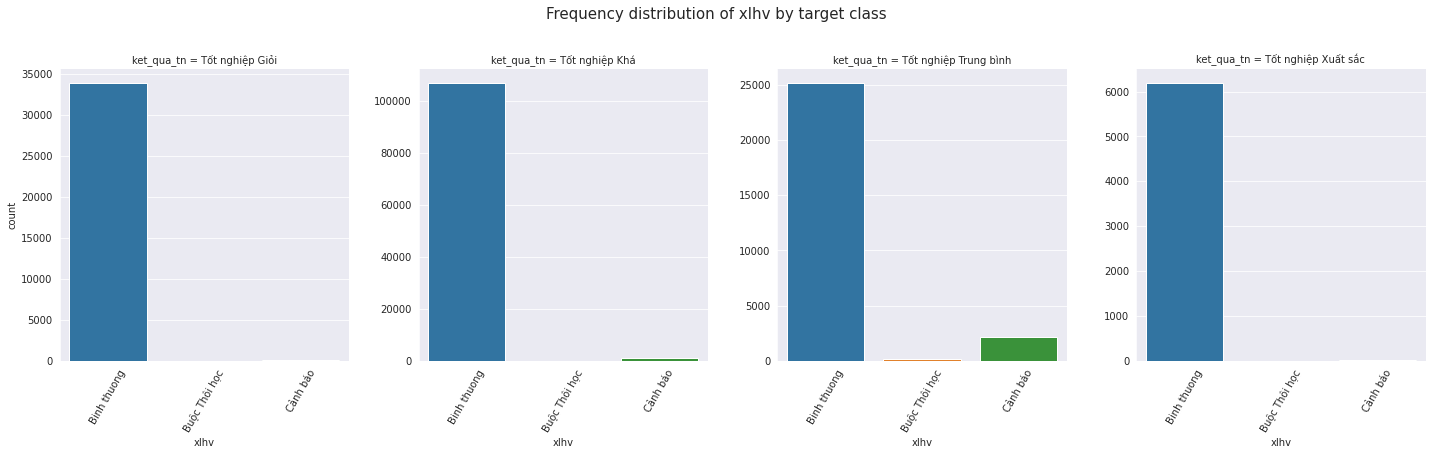

In [ ]:
cat_features = ['nganh', 'gioi_tinh', 'doi_tuong',	'khu_vuc',	'khoi_ts',	'hoc_ky',	'xlhv']
for feature in cat_features:
    plt.figure(figsize = (10, 5))
    catplot = sns.catplot(data = data, x = feature, col = 'ket_qua_tn', kind = 'count', sharey = False)
    catplot.set_xticklabels(rotation = 60)
    plt.suptitle("Frequency distribution of {} by target class".format(feature), y = 1.1, fontsize = 15)
    plt.show()

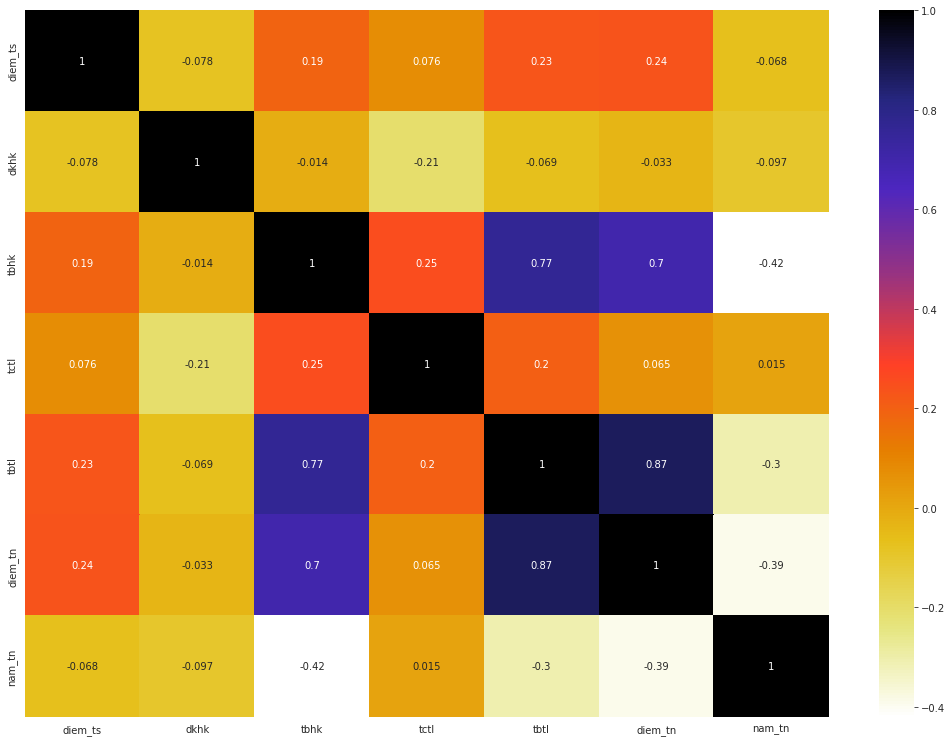

In [ ]:
# Correlation structure of features
def heatmap(data):
    plt.figure(figsize = (18, 13))
    sns.heatmap(data.corr(), annot = True, cmap = plt.cm.CMRmap_r)

heatmap(data[num_cols])

Cột **tbtl, diem_tn, tbhk** có tương quan cao => Drop 2 trong 3 cột

# Data Processing

In [ ]:
numerical_cols = ['diem_ts', 'dkhk', 'tbhk', 'tctl', 'tbtl', 'diem_tn', 'nam_tn']
ordinal_cols = ['hoc_ky', 'xlhv', 'ket_qua_tn']
nominal_cols = [x for x in data.columns if x not in numerical_cols + ordinal_cols]

In [ ]:
def label_encoder(data, cols):
    data_le = data.copy(deep = True)
    le = LabelEncoder()
    for col in cols:    
        data_le[col] = le.fit_transform(data_le[col])
    return data_le

In [ ]:
# Creating the mappings
hoc_ky_dict = {'1' : 1, '2' : 2, '3' : 3, '4' : 4, '5' : 5, '6' : 6, '7' : 7, '8' : 8, 'After semester 8' : 9}
xlhv_dict = {'Binh thuong' : 1, 'Cảnh báo' : 2, 'Buộc Thôi học' : 3}
ket_qua_tn_dict = {'Tốt nghiệp Xuất sắc': 1, 'Tốt nghiệp Giỏi': 2, 'Tốt nghiệp Khá': 3, 'Tốt nghiệp Trung bình': 4}

In [ ]:
ordinal_encoder_dict = {'hoc_ky' : hoc_ky_dict,
                       'xlhv' : xlhv_dict,
                        'ket_qua_tn': ket_qua_tn_dict
                        }

In [ ]:
def manual_encoder(data, ordinal_cols, ordinal_encoder_dict):
    data_me = data.copy(deep = True)
    for feature in data.columns:
        if feature in ordinal_cols:
            if feature != 'ket_qua_tn':
                data_me[feature] = data_me[feature].map(ordinal_encoder_dict[feature])
    return data_me

In [ ]:
data = manual_encoder(data, ordinal_cols, ordinal_encoder_dict)
data = label_encoder(data, nominal_cols)
data.head()

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,diem_ts,hoc_ky,dkhk,tbhk,tctl,tbtl,xlhv,diem_tn,ket_qua_tn,nam_tn
0,6708,3,1,0,3,0,20.0,1,22,2.60,22.0,2.60,1,3.35,Tốt nghiệp Giỏi,4.0
1,6709,3,1,0,3,0,20.0,1,22,2.50,19.0,2.50,1,2.55,Tốt nghiệp Khá,4.0
2,6710,3,1,0,3,0,20.0,1,22,2.80,22.0,2.80,1,3.02,Tốt nghiệp Khá,4.0
3,6711,3,0,0,3,0,20.0,1,22,2.25,19.0,2.25,1,2.52,Tốt nghiệp Khá,4.0
4,6712,3,0,0,3,0,20.0,1,22,2.20,22.0,2.20,1,2.09,Tốt nghiệp Trung bình,4.0


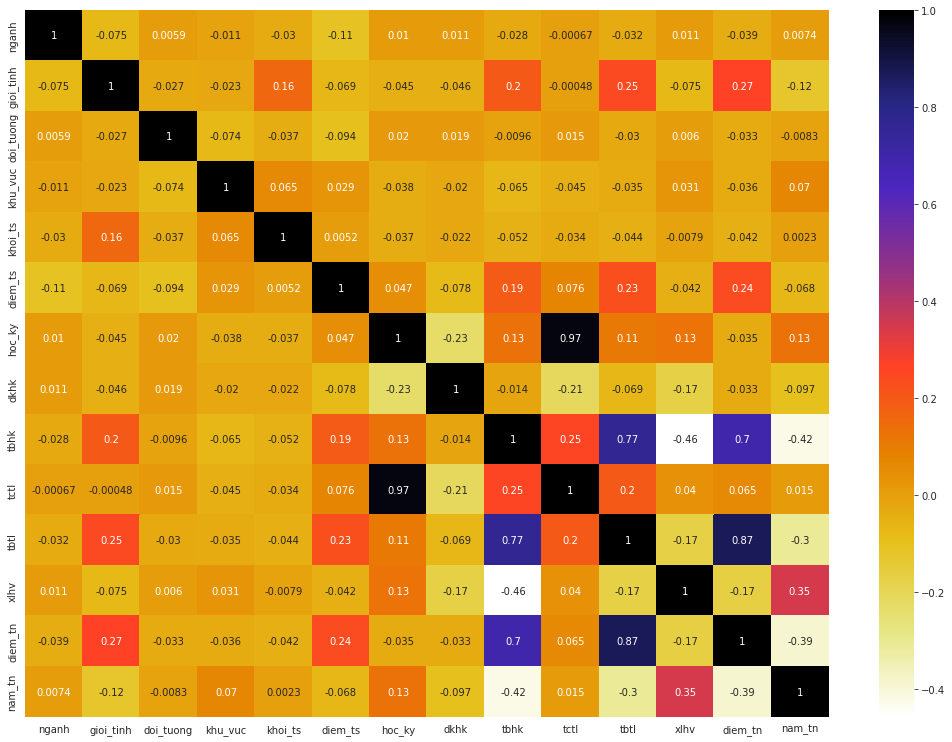

In [ ]:
data_heat = data.drop(['id', 'ket_qua_tn'], axis = 1)
heatmap(data_heat)

- Cột **tbtl, diem_tn, tbhk** có tương quan cao
- Cột **tctl, hoc_ky** có tương quan cao

In [ ]:
# Drop columns
drop_cols = ['tbhk', 'diem_tn', 'tctl', 'id']
data = data.drop(drop_cols, axis = 1)

In [ ]:
def predictor_target_split(data, target):
    y = data[target] # target variable
    X = data.drop(target, axis = 1) 
    return X, y

X, y = predictor_target_split(data, 'ket_qua_tn')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(140668, 11) (35168, 11) (140668,) (35168,)


In [ ]:
# SMOTE

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", X_train.shape, y_train.shape)

Class= Tốt nghiệp Giỏi, n=27162 (19.31%)
Class= Tốt nghiệp Trung bình, n=22099 (15.71%)
Class= Tốt nghiệp Khá, n=86436 (61.45%)
Class= Tốt nghiệp Xuất sắc, n=4971 (3.53%)
Class= Tốt nghiệp Giỏi, n=86436 (25.00%)
Class= Tốt nghiệp Trung bình, n=86436 (25.00%)
Class= Tốt nghiệp Khá, n=86436 (25.00%)
Class= Tốt nghiệp Xuất sắc, n=86436 (25.00%)
Upsampled data shape:  (345744, 11) (345744,)


In [ ]:
# Encoding the target variable
y_train = y_train.map(ordinal_encoder_dict['ket_qua_tn'])
y_test = y_test.map(ordinal_encoder_dict['ket_qua_tn'])

In [ ]:
# estimator = XGBClassifier(n_estimators = 113, learning_rate = 0.1, n_jobs = -1)
# selector = lgbE(estimator, n_features_to_select = 11, step = 1)
# selector = selector.fit(X_train, y_train)

In [ ]:
# dict = {'Feature': X_train.columns, 'Ranking': selector.ranking_}
# ranking_df = pd.DataFrame(dict)
# ranking_df

In [ ]:
# Computation of confusion matrix
def conf_mat(y_pred, y_test):
    class_names = ['Tốt nghiệp Xuất sắc', 'Tốt nghiệp Giỏi', 'Tốt nghiệp Khá', 'Tốt nghiệp Trung bình']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrix_df = pd.DataFrame(conf_matrix, range(4), range(4))
    plt.figure(figsize = (6, 4.75))
    sns.set(font_scale = 1.4) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": 16}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = ')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

In [ ]:
f1_dict = {}

Weighted F1-score on the test set: 0.8356441628112139


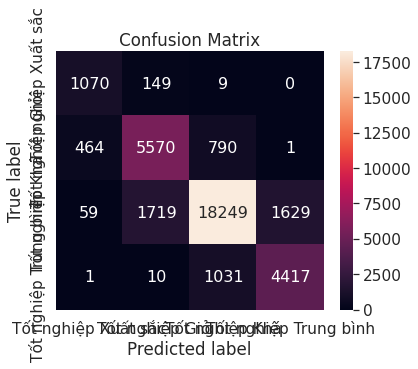

In [ ]:
lgb = LGBMClassifier(objective = 'multi', random_state = 1, n_jobs = -1, learning_rate = 0.15, n_estimators = 100)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['Random Forest'] = score
conf_mat(y_pred, y_test)

Weighted F1-score on the test set: 0.8322919853375019


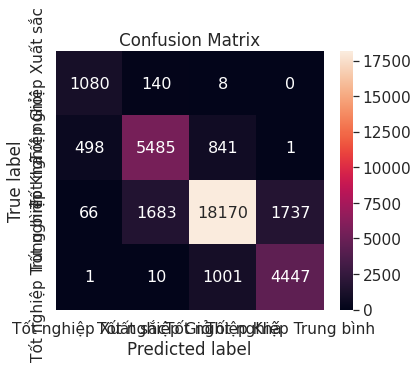

In [ ]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['Random Forest'] = score
conf_mat(y_pred, y_test)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters: {'bagging_fraction': 0.6, 'feature_fraction': 0.3, 'lambda_l1': 0.6, 'lambda_l2': 0.09, 'max_bin': 20, 'max_depth': 7, 'min_child_weight': 7, 'min_split_gain': 0.05, 'num_leaves': 40}
Best weighted F1-score: 0.8566698734301473
 
Weighted F1-score on the test set: 0.7989469893969401


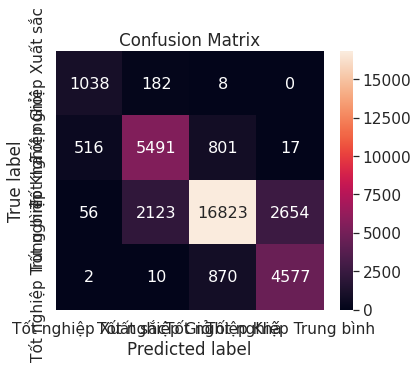

In [ ]:
f1_dict_ht = {}

# Hyperparameter tuning for Random Forest
cv = KFold(n_splits = 5, shuffle = True, random_state = 20).split(X = X_train, y = y_train)
lgb = LGBMClassifier()
params_lgb = {
    'num_leaves': [30, 40], 
    'feature_fraction': [0.2, 0.3],
    'bagging_fraction': [0.6, 0.7],
    'max_depth':[3, 5, 7],
    'max_bin':[20],
    'lambda_l1':[0.3, 0.6],
    'lambda_l2':[0.08, 0.09],
    'min_split_gain':[0.04, 0.05],
    'min_child_weight':[7]
}
gsearch_lgb = GridSearchCV(estimator = lgb, param_grid = params_lgb, scoring = 'f1_weighted', n_jobs = -1, cv = cv, verbose = 3)
gsearch_lgb_fit = gsearch_lgb.fit(X = X_train, y = y_train)
print("Best parameters: {}".format(gsearch_lgb.best_params_))
print("Best weighted F1-score: {}".format(gsearch_lgb.best_score_))
print(" ")

# Random Forest model evaluation on the test set
lgb_best = gsearch_lgb.best_estimator_
lgb_best.fit(X_train, y_train)
y_pred_lgb = lgb_best.predict(X_test)
score = f1_score(y_test, y_pred_lgb, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict_ht['Random Forest'] = score
conf_mat(y_pred_lgb, y_test)

In [66]:
a = confusion_matrix(y_pred_lgb, y_test)
a

array([[ 1038,   516,    56,     2],
       [  182,  5491,  2123,    10],
       [    8,   801, 16823,   870],
       [    0,    17,  2654,  4577]])

In [56]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

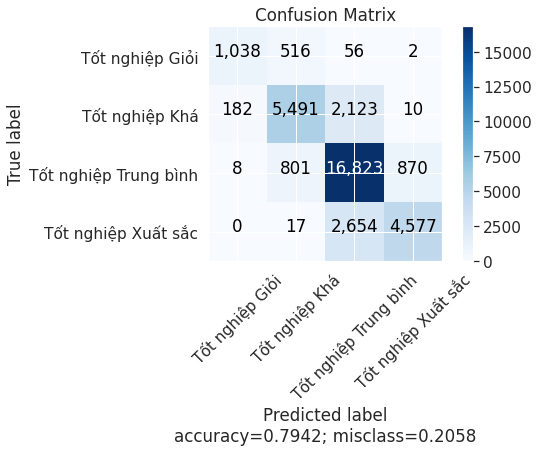

In [67]:
plot_confusion_matrix(cm           = a, 
                      normalize    = False,
                      target_names = data['ket_qua_tn'].unique(),
                      title        = "Confusion Matrix")

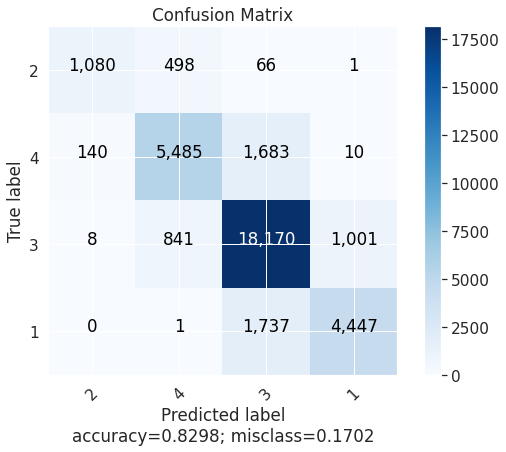

In [60]:
plot_confusion_matrix(cm           = a, 
                      normalize    = False,
                      target_names = ,
                      title        = "Confusion Matrix")

In [68]:
print(classification_report(y_pred_lgb, y_test))

              precision    recall  f1-score   support

           1       0.85      0.64      0.73      1612
           2       0.80      0.70      0.75      7806
           3       0.78      0.91      0.84     18502
           4       0.84      0.63      0.72      7248

    accuracy                           0.79     35168
   macro avg       0.82      0.72      0.76     35168
weighted avg       0.80      0.79      0.79     35168



In [64]:
y_test.value_counts()

3    21656
2     6825
4     5459
1     1228
Name: ket_qua_tn, dtype: int64